En esta notebook vamos a construir y comparar varios modelos de clasificación de sentimientos aplicados a tweets, utilizando distintas representaciones del lenguaje. Comenzaremos cargando un conjunto de datos etiquetado (`tweet_eval`) y aplicaremos preprocesamiento de texto con NLTK. Luego, transformaremos el texto en vectores mediante tres técnicas distintas: **Bag of Words**(CountVectorizer), **embeddings preentrenados de GloVe**, y **representaciones semánticas con Sentence-BERT**. Con cada representación entrenaremos y evaluaremos modelos clásicos como **Regresión Logística**, **Naive Bayes** y **Random Forest**, midiendo su desempeño con métricas como Accuracy, AUC y F1-score. Finalmente, probaremos un modelo preentrenado ya disponible a través de `pysentimiento` y compararemos todos los resultados para identificar cuál enfoque es más eficaz en esta tarea.


###1. Instalación de dependencias necesarias e importación de Librerías

In [ ]:
!pip install --upgrade --force-reinstall fsspec==2023.6.0

  Using cached fsspec-2023.6.0-py3-none-any.whl.metadata (6.7 kB)
Using cached fsspec-2023.6.0-py3-none-any.whl (163 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.7.1 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.


In [ ]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import json
import os

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

##2. Carga del dataset de tweets y preparación básica

In [ ]:
df = load_dataset("tweet_eval", "sentiment")["train"].to_pandas()
df["positive"] = (df["label"] == 2).astype(int)
df_small = df.groupby("positive").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df_small["text"], df_small["positive"], stratify=df_small["positive"], random_state=42
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-2-4ff255f70588>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby("positive").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)


##3. Preprocesamiento de texto con NLTK

In [ ]:
stopwords_en = set(stopwords.words("english")).union(set(punctuation))
wnl = WordNetLemmatizer()

def penn2morphy(tag):
    return {"NN": "n", "JJ": "a", "VB": "v", "RB": "r"}.get(tag[:2], "n")

def preprocess(text):
    return [wnl.lemmatize(w.lower(), pos=penn2morphy(t))
            for w, t in pos_tag(word_tokenize(text))
            if w.lower() not in stopwords_en and w.isalpha()]


Funciones para guardar y evaluar resultados

In [ ]:

# Función para guardar resultados en JSON
def guardar_resultado(nombre_modelo, accuracy, auc, f1, ruta="resultados_modelos.json"):
    try:
        with open(ruta, "r") as f:
            resultados = json.load(f)
    except FileNotFoundError:
        resultados = {}

    resultados[nombre_modelo] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Positivo": f1
    }

    with open(ruta, "w") as f:
        json.dump(resultados, f, indent=2)

# Función general de evaluación
def evaluar_y_guardar(nombre_modelo, clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    y_proba = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else None
    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba) if y_proba is not None else None
    f1 = classification_report(y_te, y_pred, output_dict=True)["1"]["f1-score"]
    guardar_resultado(nombre_modelo, acc, auc, f1)


##4. Modelos

###4.1 Vectorización BoW con CountVectorizer personalizado

Bag of Words (BoW) convierte el texto en una matriz de ocurrencias de palabras (frecuencias), sin considerar el significado. En este caso, se usa un CountVectorizer con una función de preprocesamiento propia (lemmatización, remoción de stopwords, etc.). Es un enfoque simple y eficaz para tareas básicas de clasificación, ideal como punto de partida.

➡️ Ventaja: fácil de implementar y entender.
➡️ Limitación: no captura el significado de las palabras ni el contexto.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=preprocess)
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)


In [ ]:

# Aplicar y guardar para los 3 modelos
evaluar_y_guardar("CountVectorizer + LogisticRegression", LogisticRegression(max_iter=1000), X_train_cv, X_test_cv, y_train, y_test)
evaluar_y_guardar("CountVectorizer + MultinomialNB", MultinomialNB(), X_train_cv, X_test_cv, y_train, y_test)
evaluar_y_guardar("CountVectorizer + RandomForest", RandomForestClassifier(max_depth=5, random_state=42), X_train_cv, X_test_cv, y_train, y_test)

#  Ver los resultados acumulados
with open("resultados_modelos.json", "r") as f:
    import pandas as pd
    df_resultados = pd.DataFrame(json.load(f)).T
    display(df_resultados.sort_values("F1 Positivo", ascending=False))


,Accuracy,AUC,F1 Positivo
CountVectorizer + LogisticRegression,0.60,0.5832,0.583333
CountVectorizer + MultinomialNB,0.54,0.5584,0.540000
CountVectorizer + RandomForest,0.54,0.5376,0.425000


###4.2 Embedding Pre Entrenado Glove

GloVe (Global Vectors for Word Representation) ofrece vectores preentrenados que representan palabras en un espacio semántico, basados en su coocurrencia. En la notebook, cada texto se representa como el promedio de los vectores de sus palabras.

➡️ Ventaja: incorpora semántica (palabras similares están cerca en el espacio vectorial).

➡️ Limitación: las representaciones son estáticas, no consideran el contexto de la palabra en una frase.



In [ ]:
!pip install --upgrade --force-reinstall numpy==1.23.5 scipy==1.9.3 gensim==4.3.1

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.4 MB)
Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Atte

Para cada palabra en los tokens, si existe en el vocabulario de GloVe (glove_model), se busca su vector de 50 dimensiones.

Se arma una lista de vectores correspondientes a las palabras del texto.

Si al menos una palabra tiene vector GloVe, se calcula el promedio de todos los vectores → esto da una única representación del texto.

Si ninguna palabra está en GloVe, se devuelve un vector nulo (ceros) para evitar errores.

Porque es una forma simple de resumir la semántica general del texto sin importar el orden de las palabras. Aunque pierde información contextual, permite representar frases o documentos completos con una sola estructura vectorial.

In [ ]:
import gensim.downloader
import numpy as np
glove_model = gensim.downloader.load("glove-wiki-gigaword-50")

def embed_glove(text):
    tokens = preprocess(text)
    vectors = [glove_model[w] for w in tokens if w in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)

X_train_glove = np.vstack([embed_glove(t) for t in X_train])
X_test_glove = np.vstack([embed_glove(t) for t in X_test])


<ipython-input-9-ad85d4ca9f98>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('positive').apply(lambda x: x.sample(10, random_state=42)).reset_index(drop=True)


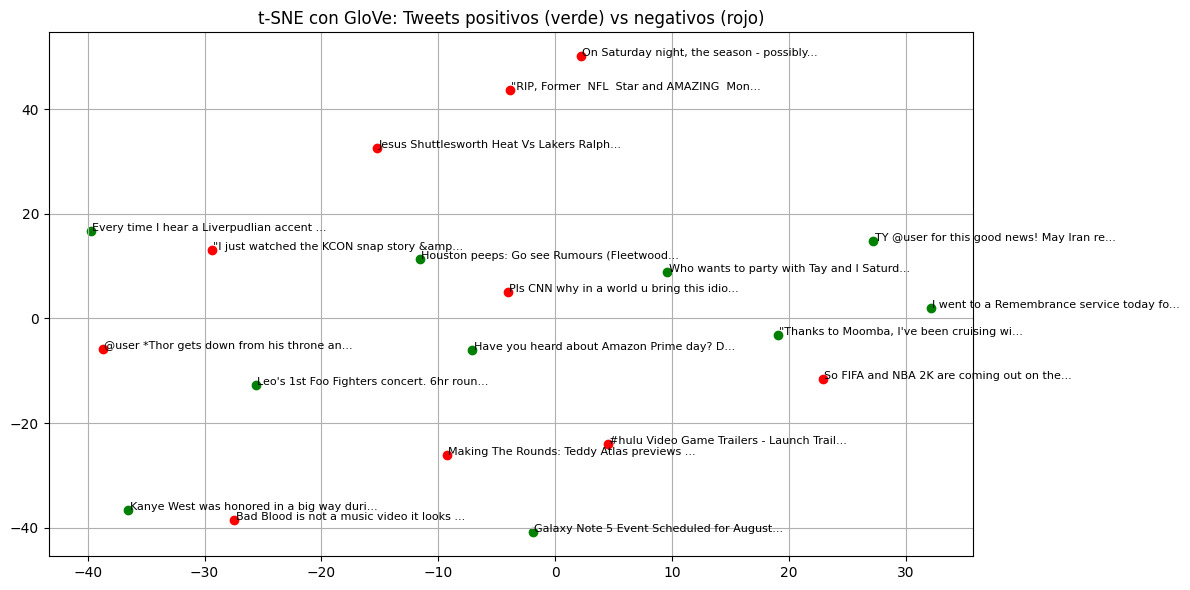

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener:
# - df: dataframe con columna 'text' y 'positive'
# - preprocess() definida
# - glove_model ya cargado

# Muestra equilibrada de 10 positivos y 10 negativos
df_sample = df.groupby('positive').apply(lambda x: x.sample(10, random_state=42)).reset_index(drop=True)

# Generar embeddings GloVe
def embed_glove(text):
    tokens = preprocess(text)
    vectors = [glove_model[w] for w in tokens if w in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)

texts = df_sample["text"].tolist()
labels = df_sample["positive"].tolist()
embeddings = np.array([embed_glove(t) for t in texts])

# Reducimos a 2D con t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
proj_tsne = tsne.fit_transform(embeddings)

# Visualización con anotaciones
colors = ['green' if l == 1 else 'red' for l in labels]
plt.figure(figsize=(12, 6))
for i, (x, y) in enumerate(proj_tsne):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.1, y, texts[i][:40] + "...", fontsize=8)
plt.title("t-SNE con GloVe: Tweets positivos (verde) vs negativos (rojo)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Lo que funciona bien**
* Separación parcial por color:

Se observan algunos agrupamientos de tweets y rojos (negativos) en la parte superior del grafico, lo cual sugiere que GloVe logra capturar cierta información semántica útil.

Distribución no aleatoria:

Los puntos no están completamente mezclados. Hay cierta estructura semántica en el plano.

** Lo que puede mejorarse o limita el resultado**

**Tweets con vocabulario general:**

Algunos tweets como “@user Thor gets down...” o “Jesus Shuttlesworth...” contienen referencias culturales o nombres que GloVe no puede interpretar bien en cuanto a polaridad emocional.

**GloVe es estático y genérico:**

GloVe fue entrenado en texto general, por lo que no fue optimizado para lenguaje informal, irónico o contextualizado como el de Twitter.

**Promediar vectores pierde estructura:**

Al usar el promedio, se pierde el orden y matices de las frases. Ej.: “no está mal” y “mal” pueden terminar similares.


** Conclusión**
✔️ Este gráfico muestra que GloVe puede ser útil como punto de partida, y los resultados no son aleatorios.

❌ Pero no es suficiente para distinguir claramente tweets positivos y negativos en todos los casos.

**Modelos más sofisticados como BERT o Sentence Transformers pueden hacer una gran diferencia.**

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import json
import os


# Función para guardar resultados en JSON
def guardar_resultado(nombre_modelo, accuracy, auc, f1, ruta="resultados_modelos.json"):
    try:
        with open(ruta, "r") as f:
            resultados = json.load(f)
    except FileNotFoundError:
        resultados = {}

    resultados[nombre_modelo] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Positivo": f1
    }

    with open(ruta, "w") as f:
        json.dump(resultados, f, indent=2)

# Función general de evaluación
def evaluar_y_guardar(nombre_modelo, clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    y_proba = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else None
    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba) if y_proba is not None else None
    f1 = classification_report(y_te, y_pred, output_dict=True)["1"]["f1-score"]
    guardar_resultado(nombre_modelo, acc, auc, f1)


# Entrenar y guardar resultado en el JSON
evaluar_y_guardar(
    nombre_modelo="GloVe + LogisticRegression",
    clf=LogisticRegression(max_iter=1000),
    X_tr=X_train_glove,
    X_te=X_test_glove,
    y_tr=y_train,
    y_te=y_test
)


In [ ]:
import pandas as pd
with open("resultados_modelos.json", "r") as f:
    df_resultados = pd.DataFrame(json.load(f)).T
    display(df_resultados.sort_values("AUC", ascending=False))


,Accuracy,AUC,F1 Positivo
CountVectorizer + LogisticRegression,0.60,0.5832,0.583333
GloVe + LogisticRegression,0.53,0.5784,0.525253
CountVectorizer + MultinomialNB,0.54,0.5584,0.540000
CountVectorizer + RandomForest,0.54,0.5376,0.425000


 pesar de que GloVe aporta información semántica más rica que un simple conteo de palabras como CountVectorizer, hay varias razones por las que CountVectorizer + LogisticRegression puede superar a GloVe + LogisticRegression en este experimento específico:

1. Pérdida de información al promediar vectores GloVe
En GloVe + LogisticRegression, cada texto se representa como el promedio de los vectores de sus palabras. Esto:

   Elimina el orden de las palabras

   Suaviza o diluye el efecto de palabras importantes

   Si un tweet tiene una palabra muy cargada emocionalmente, su efecto puede perderse entre otras palabras más neutras al promediar.

2. GloVe no considera contexto
  GloVe asigna el mismo vector a una palabra siempre, sin importar el contexto.
  Ejemplo: "cool" en “cool weather” vs “cool idea” → mismo vector.

  Esto lo limita frente a modelos contextuales como SBERT, y frente a BoW en tareas muy sensibles a palabras clave.

3. GloVe requiere más datos para brillar
  Embeddings como GloVe suelen rendir mejor cuando se usan en combinación con modelos más sofisticados (LSTM, CNN) o con más datos de entrenamiento.

En este caso, al usar solo 200 ejemplos por clase, el modelo puede no tener suficiente información para aprovechar la semántica embebida.




###4.3 Embedding con Sentence-Transformer

Este enfoque usa Sentence-BERT, una variante de BERT optimizada para generar representaciones vectoriales de oraciones, no solo palabras.
 Aquí se transforma cada tweet en un vector denso que capta relaciones semánticas más profundas.

➡️ Ventaja: representa frases completas y su contexto. Excelente para tareas como clasificación, similitud y búsqueda.

➡️ Limitación: más pesado computacionalmente que BoW o GloVe.

Qué problema resuelve?
GloVe y Word2Vec generan embeddings palabra por palabra, sin considerar el contexto completo.
Ejemplo:

"I love this" y "I don't love this" → muy parecidos si los promediás.

sentence-transformers, en cambio, entiende el significado del conjunto de palabras, porque:

Usa modelos tipo BERT que fueron entrenados para codificar frases con contexto.

Permite comparar frases, encontrar similitudes, clasificar sentimientos, etc., con mucho más poder semántico.

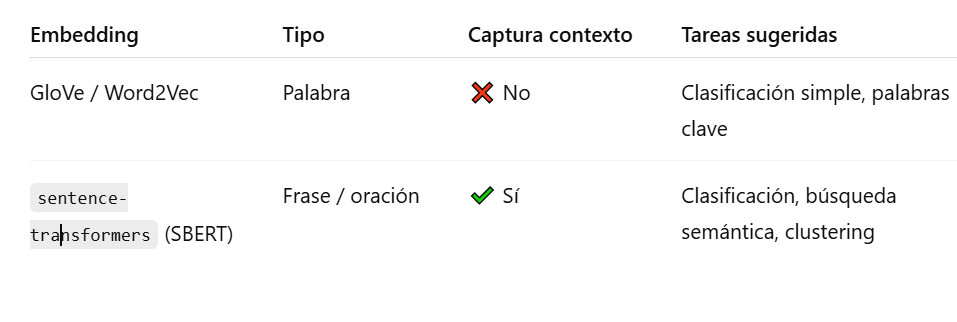

In [ ]:
!pip install -U --force-reinstall sentence-transformers transformers torch torchvision


  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached huggingface_hub-0.32.4-py3-none-any.whl.metadata (14 kB)
  Using cached pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached packaging-25

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

X_train_sbert = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(X_test.tolist(), show_progress_bar=True)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import json
import os


#  Función para guardar resultados en JSON
def guardar_resultado(nombre_modelo, accuracy, auc, f1, ruta="resultados_modelos.json"):
    try:
        with open(ruta, "r") as f:
            resultados = json.load(f)
    except FileNotFoundError:
        resultados = {}

    resultados[nombre_modelo] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Positivo": f1
    }

    with open(ruta, "w") as f:
        json.dump(resultados, f, indent=2)

#  Función general de evaluación
def evaluar_y_guardar(nombre_modelo, clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    y_proba = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else None
    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba) if y_proba is not None else None
    f1 = classification_report(y_te, y_pred, output_dict=True)["1"]["f1-score"]
    guardar_resultado(nombre_modelo, acc, auc, f1)


evaluar_y_guardar(
    nombre_modelo="SBERT + LogisticRegression",
    clf=LogisticRegression(max_iter=1000),
    X_tr=X_train_sbert,
    X_te=X_test_sbert,
    y_tr=y_train,
    y_te=y_test
)


In [ ]:
import pandas as pd
with open("resultados_modelos.json", "r") as f:
    df_resultados = pd.DataFrame(json.load(f)).T
    display(df_resultados.sort_values("AUC", ascending=False))

,Accuracy,AUC,F1 Positivo
SBERT + LogisticRegression,0.67,0.7220,0.666667
CountVectorizer + LogisticRegression,0.60,0.5832,0.583333
GloVe + LogisticRegression,0.53,0.5784,0.525253
CountVectorizer + MultinomialNB,0.54,0.5584,0.540000
CountVectorizer + RandomForest,0.54,0.5376,0.425000


Visualización t-SNE


<ipython-input-4-0d7121d8a572>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('positive').apply(lambda x: x.sample(10, random_state=42)).reset_index(drop=True)


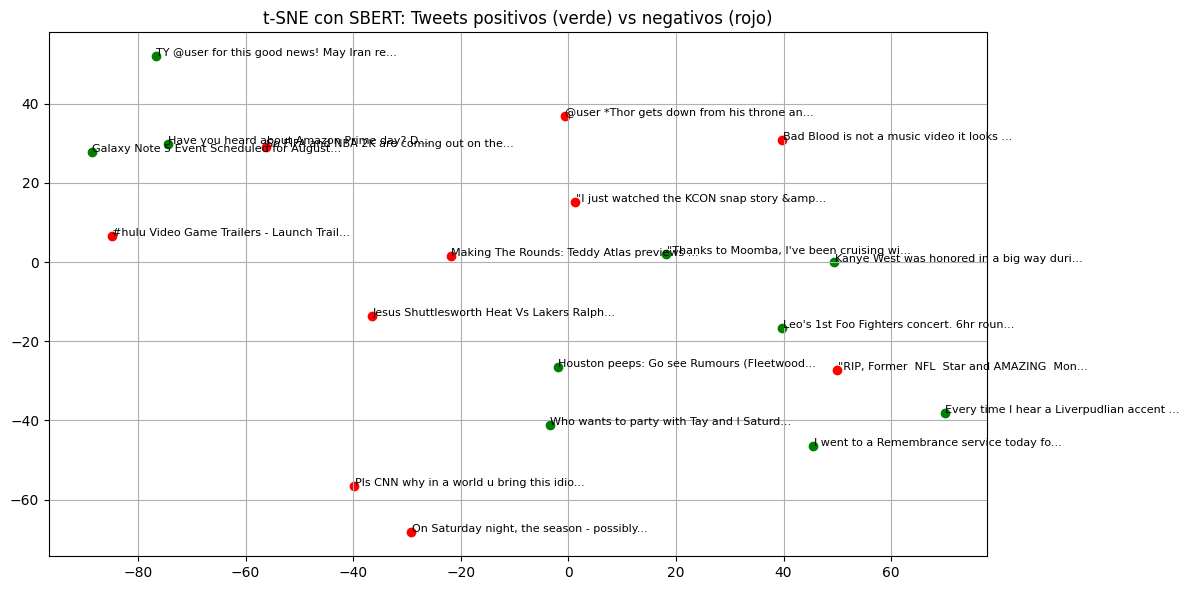

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer

# Asegúrate de tener:
# - df: dataframe con columna 'text' y 'positive'
# - sbert_model ya cargado (ej: SentenceTransformer("all-MiniLM-L6-v2"))

# Muestra equilibrada de 10 positivos y 10 negativos
df_sample = df.groupby('positive').apply(lambda x: x.sample(10, random_state=42)).reset_index(drop=True)

# Obtener textos y etiquetas
texts = df_sample["text"].tolist()
labels = df_sample["positive"].tolist()

# Generar embeddings con SBERT
embeddings_sbert = sbert_model.encode(texts, show_progress_bar=False)

# Reducimos a 2D con t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
proj_tsne = tsne.fit_transform(embeddings_sbert)

# Visualización con anotaciones
colors = ['green' if l == 1 else 'red' for l in labels]
plt.figure(figsize=(12, 6))
for i, (x, y) in enumerate(proj_tsne):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.1, y, texts[i][:40] + "...", fontsize=8)
plt.title("t-SNE con SBERT: Tweets positivos (verde) vs negativos (rojo)")
plt.grid(True)
plt.tight_layout()
plt.show()



Hay agrupamientos suaves: varios tweets verdes (positivos) tienden a estar cerca de otros verdes, lo mismo para los rojos.

No hay una distribución completamente aleatoria: eso indica que SBERT está capturando algunas similitudes semánticas reales.

muestra que SBERT mejora respecto a GloVe, pero no es perfecto sin fine-tuning ni sin suficiente cantidad de datos.

Factor Qué afecta
❗ Muy pocos ejemplos t-SNE no tiene suficiente estructura que preservar.

💬 Tweets informales SBERT fue entrenado en oraciones formales (Wikipedia, SNLI), no en lenguaje de Twitter.

📦 Embedding de frase sin fine-tuning El modelo no está adaptado al dominio (sentimiento en Twitter).




###4.4 Modelo preentrenado Pysentimiento

Este modelo ya está entrenado específicamente para analizar sentimiento en textos en inglés (tweets, opiniones, etc.). No requiere entrenamiento adicional: simplemente se le pasa el texto y devuelve una predicción.

➡️ Ventaja: muy rápido de aplicar, ya optimizado para la tarea.

➡️ Limitación: no se puede adaptar fácilmente a un nuevo dominio o idioma.



In [ ]:
!pip install pysentimiento --quiet

In [ ]:

from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="en")
y_pred_pysentimiento = [1 if analyzer.predict(t).output == "POS" else 0 for t in X_test]


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

report = classification_report(y_test, y_pred_pysentimiento, output_dict=True)
acc = accuracy_score(y_test, y_pred_pysentimiento)
f1 = report["1"]["f1-score"]


In [ ]:
guardar_resultado(
    nombre_modelo="Pysentimiento (preentrenado)",
    accuracy=acc,
    auc=None,
    f1=f1
)


In [ ]:
import pandas as pd

with open("resultados_modelos.json", "r") as f:
    df_resultados = pd.DataFrame(json.load(f)).T
    display(df_resultados.sort_values("F1 Positivo", ascending=False))


,Accuracy,AUC,F1 Positivo
Pysentimiento (preentrenado),0.90,NaN,0.895833
SBERT + LogisticRegression,0.67,0.7220,0.666667
CountVectorizer + LogisticRegression,0.60,0.5832,0.583333
CountVectorizer + MultinomialNB,0.54,0.5584,0.540000
GloVe + LogisticRegression,0.53,0.5784,0.525253
CountVectorizer + RandomForest,0.54,0.5376,0.425000


## Resumen de Resultados y Comparación de Modelos


### Conclusiones clave:

- **Pysentimiento**, modelo preentrenado optimizado para sentimiento en inglés, ofrece el mejor desempeño sin entrenamiento adicional.
- **SBERT** combinado con regresión logística supera ampliamente a los enfoques tradicionales al capturar contexto semántico.
- **GloVe**, aunque incorpora semántica, pierde efectividad al promediar vectores y no captar el contexto.
- **Modelos clásicos con Bag of Words** son útiles como baseline, pero muestran limitaciones ante enfoques más modernos.

### Recomendación:
Si buscás rapidez y precisión sin entrenamiento, usá **Pysentimiento**.  
Si necesitás personalización o estás fuera del dominio preentrenado, **SBERT** es la mejor opción entre los modelos entrenables.


In [ ]:
import os
os.remove("resultados_modelos.json")


In [ ]:
import json

# Sobrescribe el archivo con un diccionario vacío si quiero borrar sin elminar
with open("resultados_modelos.json", "w") as f:
    json.dump({}, f, indent=2)
